In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_and_emissions__epsg4326.geojson"
)

PATH_TO_OUTPUT = Path("../reports/figures/")

SAVE_FIG = False
axis_label_fontsize=21
axis_ticklabel_fontsize=20

RANDOM_STATE = 4
TEST_SIZE = 0.3
N_SPLITS = 5

In [3]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

gdf_rome_connected = gdf_rome.drop(index=[97]).reset_index()

(155, 36)


In [4]:
feature_to_predict = "avg_CO_2_per_road"

all_predictors = [
    'n_traffic_lights', 'density_traffic_lights', 
    'n_shops', 'density_shops', 
    'street_len_tot', 'street_density', #'motorway_ratio',
    'motorway_roads_density', 'trunk_roads_density',
    'primary_roads_density', 'all_heavy_roads_density',
    'n_food_amenities', 'density_food_amenities', 
    'n_education_amenities', 'density_education_amenities', 
    'n_service_amenities', 'density_service_amenities', 
    'n_all_amenities', 'density_all_amenities',
    'perc_roads_bc', 'car_accidents',
    'perc_people_close_to_public_transport', 'pop_density',
]

non_correlated_features = [
    'density_traffic_lights',
    'street_density',
    'motorway_roads_density',
    'trunk_roads_density',
    'primary_roads_density',
    'density_all_amenities',
    'perc_roads_bc',
    'car_accidents',
    'perc_people_close_to_public_transport',
    'pop_density'
]

## Preprocessing

In [5]:
y = gdf_rome_connected[feature_to_predict]

## y
pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

y_transformed = pd.Series(pwt.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed avg CO2 per road"

In [6]:
## X

POWER_TRANSFORM = False

X = gdf_rome_connected[non_correlated_features]

if POWER_TRANSFORM:
    pwt = PowerTransformer()
    pwt.fit(X)
    X_transformed = pd.DataFrame(pwt.transform(X), columns=X.columns)
else:
    ss = StandardScaler()
    ss.fit(X)
    X_transformed = pd.DataFrame(ss.transform(X), columns=X.columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Random Forest regressor

### First method: train on 70% of data

In [8]:
N_TREES = 100
MAX_FEATURES = 'auto' # if 'auto' = n_features
MAX_DEPTH = 5

rf = RandomForestRegressor(n_estimators = N_TREES, 
                           max_features = MAX_FEATURES, 
                           max_depth = MAX_DEPTH, 
                           random_state = RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=4)

In [9]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

def evaluate_model_predictions(truth, prediction, model_name, save_fig, file_name):
    
    res = [truth.iloc[i]-prediction[i] for i in range(len(truth))]
    
    print('> some metrics <')
    #print("Coefficients: \n", model.coef_)
    #print("Intercept: ", model.intercept_)
    mse = mean_squared_error(truth, prediction)
    rmse = mean_squared_error(truth, prediction, squared=False)
    mae = median_absolute_error(truth, prediction)
    r2 = r2_score(truth, prediction)
    print("Mean squared error: %.2f" % mse)
    print("Root mean squared error: %.2f" % rmse)
    print("Median absolute error: %.2f" % mae)
    print("Coefficient of determination: %.2f" % r2)
    print('')

    # plotting the results
    f, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].scatter(truth, prediction, color='black', s=8)
    p1 = max(max(prediction), max(truth))
    p2 = min(min(prediction), min(truth))
    axs[0].plot([p1, p2], [p1, p2], '--k')
    axs[0].set_ylabel(r'$\hat{y}$', fontsize=21)
    axs[0].set_xlabel(r'$y$', fontsize=21)
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].set_title('%s: predictions vs truth' %model_name, fontsize=22)
    axs[0].text(p2, p1-(p1/100*5), '$R^2$=%.2f, MAE=%.2f' % (
        r2_score(truth, prediction), median_absolute_error(truth, prediction)),
        fontdict={'size':21})
    axs[1].scatter(truth, res, color='black', s=8)
    axs[1].axhline(0, linestyle='--', color='black')
    axs[1].set_ylabel(r'$y-\hat{y}$', fontsize=21)
    axs[1].set_xlabel(r'$y$', fontsize=21)
    axs[1].tick_params(axis='both', which='major', labelsize=20)
    axs[1].set_title('%s: residuals' %model_name, fontsize=22)
    plt.tight_layout()

    if save_fig:
        svg_file_name = file_name+'.pdf'
        plt.savefig(PATH_TO_OUTPUT / svg_file_name, format='pdf')
        png_file_name = file_name+'.png'
        plt.savefig(PATH_TO_OUTPUT / png_file_name, format='png', dpi=300)
    
    return f, axs

> some metrics <
Mean squared error: 0.20
Root mean squared error: 0.45
Median absolute error: 0.29
Coefficient of determination: 0.83



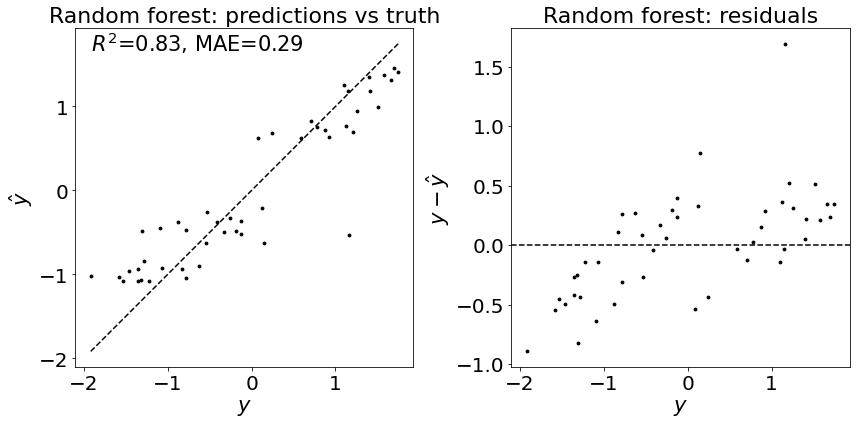

In [10]:
# predicting
y_pred = rf.predict(X_test)

fig, axs = evaluate_model_predictions(y_test, y_pred, 'Random forest', save_fig=SAVE_FIG, file_name='predictions_randomforest_test30')

### Grid search parameters

In [11]:
## Define Grid 
grid = { 
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt'], #'log2'
    'max_depth' : [None,2,3],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

## Grid Search function
rf_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=N_SPLITS)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 2, 3],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [12]:
dict_params_best_model = rf_cv.best_estimator_.get_params(deep=False)
dict_params_best_model

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

> some metrics <
Mean squared error: 0.20
Root mean squared error: 0.45
Median absolute error: 0.28
Coefficient of determination: 0.83



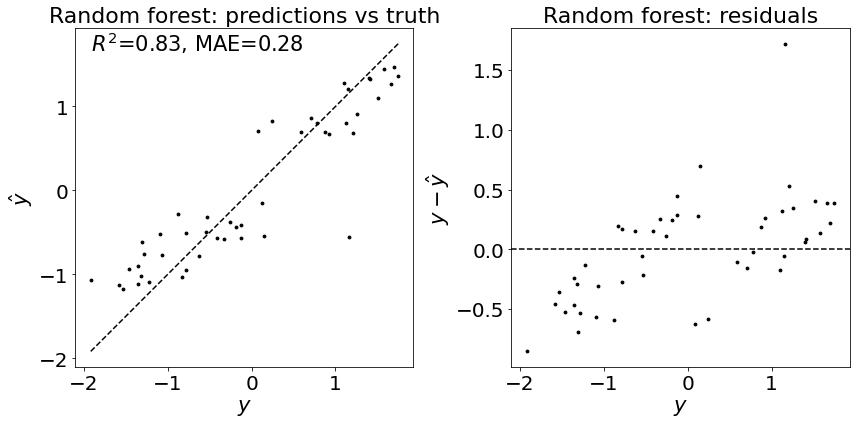

In [13]:
# predicting
y_pred = rf_cv.best_estimator_.predict(X_test)

fig, axs = evaluate_model_predictions(y_test, y_pred, 'Random forest', save_fig=SAVE_FIG, file_name='predictions_randomforest_test30')

In [14]:
N_SPLITS=5
N_REPEATS=5

cv = cross_validate(
    rf_cv.best_estimator_,
    X_test,
    y_test,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
    scoring='neg_median_absolute_error'
)
print("%0.2f with a standard deviation of %0.2f" %(cv['test_score'].mean(), cv['test_score'].std()))

-0.43 with a standard deviation of 0.13


In [15]:
gdf_to_plot = gdf_rome_connected[['area_name', 'geometry']].copy()
all_stand_errors = []
for i, c_est in enumerate(cv['estimator']):
    c_y_pred = c_est.predict(X_test)
    c_stand_error = (y_test - c_y_pred) / np.std(y_test - c_y_pred)
    all_stand_errors.append(c_stand_error)
    gdf_to_plot['error %s est.' %i] = c_stand_error

gdf_to_plot[[col for col in gdf_to_plot if 'error' in col]].mean(axis=1)

0           NaN
1     -0.586544
2     -0.522564
3           NaN
4           NaN
         ...   
149         NaN
150         NaN
151         NaN
152    0.863058
153         NaN
Length: 154, dtype: float64

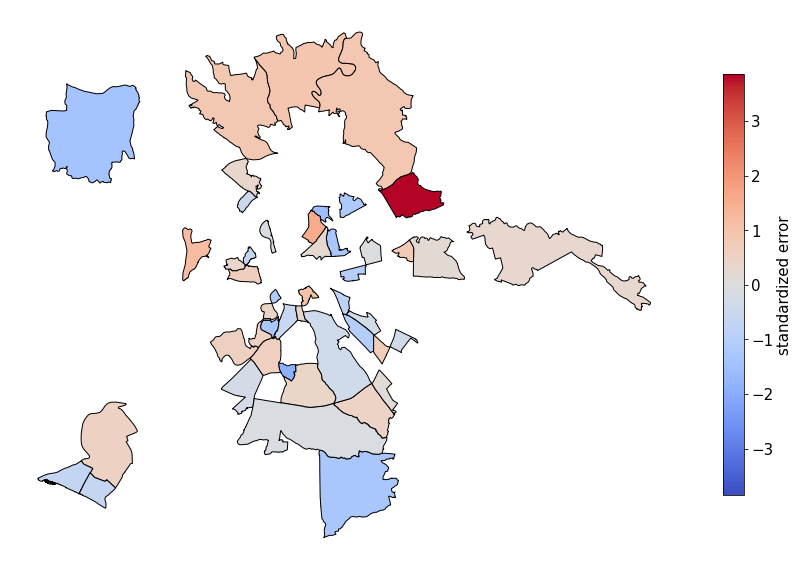

In [16]:
### model's error to plot:
truth = y_test
pred = y_pred

# scaled residuals
#error_to_plot = res_scaled   # (res - mean(res)) / std(res)

# standardized residuals
error_to_plot = (truth - pred) / np.std(truth - pred)

# SMAPE ? --> error_to_plot
#error_to_plot = 2 * (y_transformed - y_pred_transformed) / (abs(y_transformed) + abs(y_pred_transformed))


gdf_rome_connected["Chosen_Error"] = error_to_plot

col_lim = max(abs(gdf_rome_connected["Chosen_Error"].min()), abs(gdf_rome_connected["Chosen_Error"].max()))

fig, ax = plt.subplots(figsize=(12, 12))

gdf_rome_connected.plot(
    ax=ax,
    column="Chosen_Error",
    legend=True,
    #figsize=(12, 12),
    edgecolor="black",
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink": 0.5},
)
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=15)
cbar.set_ylabel('standardized error', fontsize=15)

#ax.set_title("Relative errors in linear model", fontsize=20, y=1.01)
ax.set_axis_off()
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_randomforest_test30.svg', format='svg', bbox_inches='tight')
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_randomforest_test30.png', format='png', bbox_inches='tight')

plt.show()

### Second method: Train on N-1 regions
For each area $i$, train a model on the other $N-i$ areas, and predict emissions on area $i$.

The hyperparameters are those found with grid search.

In [17]:
N_TREES = dict_params_best_model['n_estimators']
MAX_FEATURES = dict_params_best_model['max_features']
MAX_DEPTH = dict_params_best_model['max_depth']
MIN_LEAF = dict_params_best_model['min_samples_leaf']
MIN_SPLIT = dict_params_best_model['min_samples_split']

rf = RandomForestRegressor(n_estimators = N_TREES, 
                           max_features = MAX_FEATURES, 
                           max_depth = MAX_DEPTH, 
                           min_samples_leaf = MIN_LEAF,
                           min_samples_split = MIN_SPLIT,
                           random_state = RANDOM_STATE)

for c_index in gdf_rome_connected.index:
    
    c_X_train = X_transformed.drop(c_index, axis=0)
    c_X_test = X_transformed.loc[c_index]
    c_y_train = y_transformed.drop(c_index, axis=0)
    c_y_test = y_transformed.loc[c_index]
    
    rf.fit(c_X_train, c_y_train)
    
    c_y_pred = rf.predict(np.array(c_X_test).reshape(1,-1))
    c_res = c_y_test - c_y_pred
    
    gdf_rome_connected.loc[c_index, 'rf_prediction'] = c_y_pred
    gdf_rome_connected.loc[c_index, 'rf_residual'] = c_res

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f

> some metrics <
Mean squared error: 0.26
Root mean squared error: 0.51
Median absolute error: 0.35
Coefficient of determination: 0.74



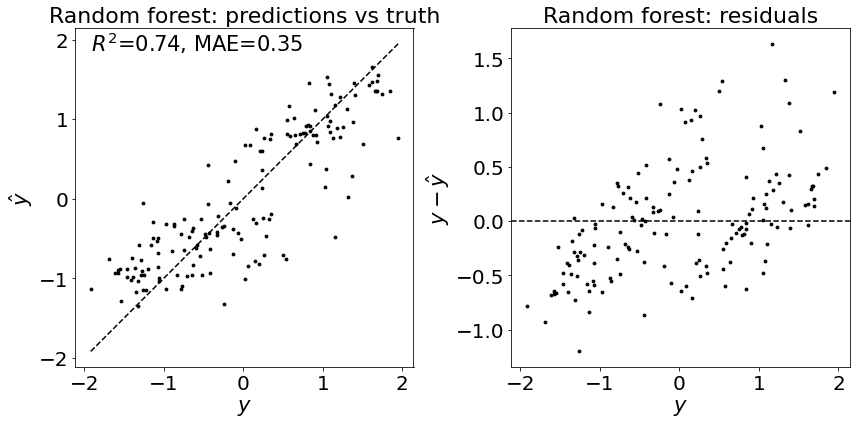

In [18]:

fig, axs = evaluate_model_predictions(y_transformed, 
                                      np.array(gdf_rome_connected['rf_prediction']), 
                                      'Random forest', 
                                      save_fig=SAVE_FIG, file_name='predictions_randomforest_leaveoneout')

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


Moran's I:  0.2172115754554649 0.001


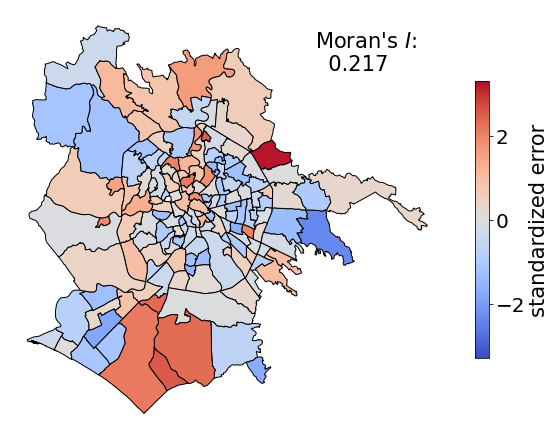

In [19]:
### model's error to plot:
truth = y_transformed
pred = np.array(gdf_rome_connected['rf_prediction'])

# scaled residuals
#error_to_plot = res_scaled   # (res - mean(res)) / std(res)

# standardized residuals
error_to_plot = (truth - pred) / np.std(truth - pred)

# SMAPE ? --> error_to_plot
#error_to_plot = 2 * (y_transformed - y_pred_transformed) / (abs(y_transformed) + abs(y_pred_transformed))

gdf_rome_connected["Chosen_Error"] = error_to_plot

## Global Moran's I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran

w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1
moran = esda.moran.Moran(gdf_rome_connected["Chosen_Error"], w)
print("Moran's I: ", moran.I, moran.p_sim)
##

col_lim = max(abs(gdf_rome_connected["Chosen_Error"].min()), abs(gdf_rome_connected["Chosen_Error"].max()))
#print(col_lim)

fig, ax = plt.subplots(figsize=(8, 8))

gdf_rome_connected.plot(
    ax=ax,
    column="Chosen_Error",
    legend=True,
    #figsize=(12, 12),
    edgecolor="black",
    cmap="coolwarm",
    vmin=-3.3,
    vmax=3.3,
    legend_kwds={"shrink": 0.5},
)
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=axis_ticklabel_fontsize)
cbar.set_ylabel('standardized error', fontsize=axis_label_fontsize)

ax.text(0.7, 0.85, "Moran's $I$: \n  %.3f" %moran.I, fontdict={'size':axis_label_fontsize}, transform=ax.transAxes)

#ax.set_title("Relative errors in linear model", fontsize=20, y=1.01)
ax.set_axis_off()
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_randomforest_leaveoneout.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_randomforest_leaveoneout.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

In [20]:
## Global Moran's I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran

# spatial weights
w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1

# 
moran = esda.moran.Moran(gdf_rome_connected["Chosen_Error"], w)
moran.I, moran.p_sim

(0.2172115754554649, 0.001)

## Feature importance

### impurity-based feature importance

https://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation

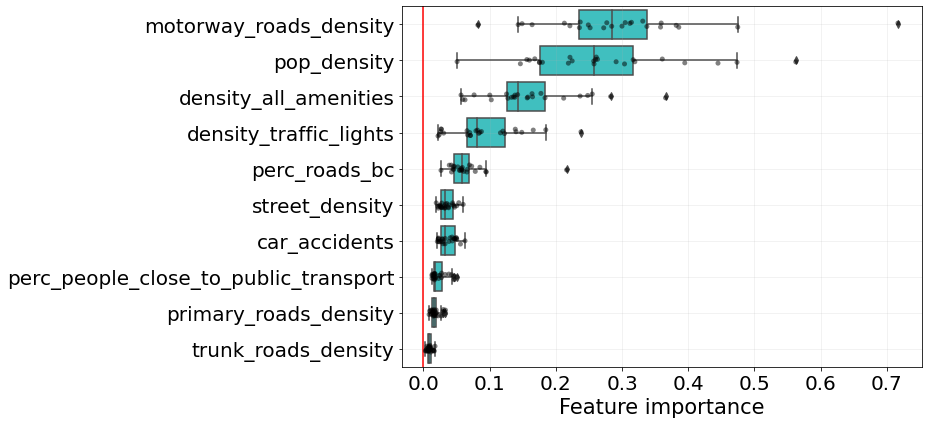

In [22]:
## impurity-based feature importance

importances = pd.DataFrame(
    [est.feature_importances_ for est in cv["estimator"]],
    columns=X.columns,
)

medians_all = importances.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
importances = importances[medians_all.index]


fig, ax = plt.subplots(figsize=(13, 6))
#plt.figure(figsize=(20, 1*len(independent_variables)))
sns.stripplot(data=importances, orient="h", color="k", alpha=0.5)
sns.boxplot(data=importances, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Feature importance", fontsize=axis_label_fontsize)
ax.grid(alpha=0.2)
#plt.title(f"Sensitivity Analysis. \n Coefficients of the regression model with uncorrelated features", fontsize=15)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'feature_importance_random_forest.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'feature_importance_random_forest.png', format='png')

plt.show()

### permutation feature importance

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance

In [20]:
## permutation feature importance

from sklearn.inspection import permutation_importance

r = permutation_importance(rf_cv.best_estimator_, 
                           X_test, y_test,
                           n_repeats=N_REPEATS,
                           random_state=RANDOM_STATE)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{rf_cv.best_estimator_.feature_names_in_[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

motorway_roads_density 0.637 +/- 0.065
pop_density 0.084 +/- 0.021
perc_roads_bc 0.059 +/- 0.017
trunk_roads_density 0.055 +/- 0.015
street_density 0.031 +/- 0.011
car_accidents 0.012 +/- 0.003
density_traffic_lights 0.011 +/- 0.003
density_all_amenities 0.009 +/- 0.004
perc_people_close_to_public_transport 0.006 +/- 0.002
primary_roads_density 0.003 +/- 0.001
